In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import networkx as nx
import sys
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from local_utils import *

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import *

from circuit_3954_dispersions import create_circuit_3954_dispersions
#find_dispersions, find_roots, find_root_original = create_circuit_3954_dispersions()

from scipy.optimize import fsolve
from scipy.linalg import eigvals

import pandas as pd

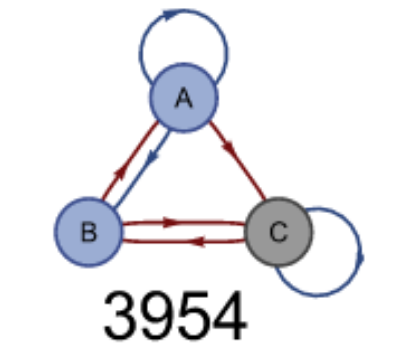

In [47]:
from IPython.display import Image
Image("3954.png")

In [12]:
def find_act_bound(func, ranges, level, args=(), is_lower=True):
    values_indices = np.nonzero(func(ranges, *args)  < level) if is_lower else np.nonzero(func(ranges, *args) > level)    
    return ranges[values_indices][-1] if is_lower else ranges[values_indices][0]

def find_inh_bound(func, ranges, level, args=(), is_lower=True):
    values_indices = np.nonzero(func(ranges, *args)  > level) if is_lower else np.nonzero(func(ranges, *args) < level)    
    return ranges[values_indices][-1] if is_lower else ranges[values_indices][0]

def find_bounds(func, ranges, level, args=(), is_act=True):
    if is_act:
        lower_bound = find_act_bound(func, ranges, level, args)
        upper_bound = find_act_bound(func, ranges, 1-level, args, is_lower=False)
    else:
        lower_bound = find_inh_bound(func, ranges, 1-level, args, is_lower=False)
        upper_bound = find_inh_bound(func, ranges, level, args)
    return (lower_bound, upper_bound)
        

def act(x, K, n):
    """Activatrion"""
    return 1 / (1 + (K / (x + 1e-30)) ** n)


def inh(x, K, n):
    """Inhibition"""
    return 1 / (1 + (x / (K + 1e-30)) ** n)

A_act_AA = lambda A, K_AA: act(A, K_AA, 4)
A_inh_BA = lambda B, K_BA: inh(B, K_BA, 4)
A_prod = lambda A, K_AA, B, K_BA: A_act_BA(A, K_AA)*A_act_BA(B, K_BA)

B_act_AB = lambda A, K_AB: act(A, K_AB, 4)
B_inh_CB = lambda C, K_CB: inh(C, K_CB, 4)
B_prod = lambda A, K_AB, C, K_CB: B_act_AB(A, K_AB)*B_inh_CB(C, K_CB)

C_inh_AC = lambda A, K_AC: inh(A, K_AC, 4)
C_inh_BC = lambda B, K_BC: inh(B, K_BC, 4)
C_act_CC = lambda C, K_CC: act(C, K_CC, 4)
C_prod = lambda A, K_AC, B, K_BC, C, K_CC: C_inh_AC(A, K_AC)*C_inh_BC(B, K_BC)*C_act_CC(C, K_CC)

def create_3954():
    A = np.array([[1, 1, -1], [-1, 0, -1], [0, -1, 1]])
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph)
    return nx.relabel_nodes(G, {0:'A', 1:'B', 2:'C'}, True)

def create_by_adj(A):    
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph)
    return nx.relabel_nodes(G, {0:'A', 1:'B', 2:'C'}, True)

def create_net(edges={}):
    A = np.array([[1, 1, -1], [-1, 0, -1], [0, -1, 1]])
    for loc,v in edges.items():
        A[loc] = v
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph)
    return nx.relabel_nodes(G, {0:'A', 1:'B', 2:'C'}, True)

def plot_net(A):
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(111)
    #plt.subplot(121);plt.title("3954")
    #nx.draw(create_3954(), with_labels=True, font_weight='bold')
    #plt.subplot(122);plt.title("Resulting 3954")
    nx.draw_circular(create_by_adj(A), ax=ax, with_labels=True, font_weight='bold')
    plt.show()

In [22]:
def creat_topology(path):
    
    with open(path, "rb") as f:
        k_max, params, res = np.load(f, allow_pickle=True)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    
    def reshape(arr, steps=1):
        T = arr.shape[0]
        ret = np.array([
            [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
            for i in range(T-steps, T)
        ])
        return np.einsum("tcxy -> cxyt", ret)

    ####################################################
    def to(arr):
        return arr.reshape(128, 128) 
    
    #############################################################
    kinetics = create_circuit_3954(n_val, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
    ###############################################################
    def analysis_act(min_, avg_, max_, lb, up):
        if max_ < lb:
            return "ZERO"
        elif min_ > up:
            return "ONE"
        else:
            return "Active"
        
    def analysis_inh(min_, avg_, max_, lb, up):
        if max_ < lb:
            return "ONE"
        elif min_ > up:
            return "ZERO"
        else:
            return "Active"       
    xs = np.linspace(0, 1000, 100000)
    # circuit 3954 adjacency matrix    
    Adj=np.array([[1, 1, -1], [-1, 0, -1], [0, -1, 1]])
    threshold = 0.001
    ###############################################################
    min_A, min_B, min_C = np.min(res[-1, :, :], axis=1)    
    avg_A, avg_B, avg_C = np.mean(res[-1, :, :], axis=1)
    max_A, max_B, max_C = np.max(res[-1, :, :], axis=1) 
    std_A, std_B, std_C = np.std(res[-1, :, :], axis=1)
    
    lb_AA, ub_AA = find_bounds(A_act_AA, xs, threshold, (K_AA_val,), True)
    analysis_AA = analysis_act(min_A, avg_A, max_A, lb_AA, ub_AA)
    if analysis_AA == "ONE":
        Adj[0,0]=0
        
    
    lb_BA, ub_BA = find_bounds(A_inh_BA, xs, threshold, (K_BA_val,), False)
    analysis_BA = analysis_inh(min_B, avg_B, max_B, lb_BA, ub_BA)
    if analysis_BA == "ONE":
        Adj[1,0]=0
    if analysis_AA == "ZERO" or analysis_BA == "ZERO":
        Adj[0,0]=Adj[1,0]=0 
    
    lb_AB, ub_AB = find_bounds(B_act_AB, xs, threshold, (K_AB_val,), True)
    analysis_AB = analysis_act(min_A, avg_A, max_A, lb_AB, ub_AB)
    if analysis_AB == "ONE":
        Adj[0,1]=0
    
    lb_CB, ub_CB = find_bounds(B_inh_CB, xs, threshold, (K_CB_val,), False)
    analysis_CB = analysis_inh(min_C, avg_C, max_C, lb_CB, ub_CB)
    if analysis_CB == "ONE":
        Adj[2,1]=0
    if analysis_AB == "ZERO" or analysis_CB == "ZERO":
        Adj[0,1]=Adj[2,1]=0
    
    lb_AC, ub_AC = find_bounds(C_inh_AC, xs, threshold, (K_AC_val,), False)
    analysis_AC = analysis_inh(min_A, avg_A, max_A, lb_AC, ub_AC)
    if analysis_AC == "ONE":
        Adj[0,2]=0
    
    lb_BC, ub_BC = find_bounds(C_inh_BC, xs, threshold, (K_BC_val,), False)
    analysis_BC = analysis_inh(min_B, avg_B, max_B, lb_BC, ub_BC)
    if analysis_BC == "ONE":
        Adj[1,2]=0
    
    lb_CC, ub_CC = find_bounds(C_act_CC, xs, threshold, (K_CC_val,), True)
    analysis_CC = analysis_act(min_C, avg_C, max_C, lb_CC, ub_CC)
    if analysis_CC == "ONE":
        Adj[2,2]=0
    if analysis_AC == "ZERO" or analysis_BC == "ZERO" or analysis_CC == "ZERO":
        Adj[0,2]=Adj[1,2]=Adj[2,2]=0
    
    #plot_net(Adj)
    return (min_A, min_B, min_C,
            avg_A, avg_B, avg_C,
            max_A, max_B, max_C,
            std_A, std_B, std_C,
            analysis_AA, lb_AA, ub_AA,
            analysis_AB, lb_AB, ub_AB,
            analysis_AC, lb_AC, ub_AC,
            analysis_BA, lb_BA, ub_BA,
            analysis_BC, lb_BC, ub_BC,
            analysis_CB, lb_CB, ub_CB,
            analysis_CC, lb_CC, ub_CC,
            Adj, k_max, params, path[2:])

In [3]:
files = !ls ./outputs_second_search/*.npy

In [4]:
len(files)

2817

In [23]:
df = pd.DataFrame([ creat_topology(file) for file in files if file.count("_") == 5], 
                  columns=["min_A", "min_B", "min_C", "avg_A", "avg_B", "avg_C",
                           "max_A", "max_B", "max_C", "std_A", "std_B", "std_C",
                           "state_AA", "lb_AA", "ub_AA",
                           "state_AB", "lb_AB", "ub_AB",
                           "state_AC", "lb_AC", "ub_AC",
                           "state_BA", "lb_BA", "ub_BA",
                           "state_BC", "lb_BC", "ub_BC",
                           "state_CB", "lb_CB", "ub_CB",
                           "state_CC", "lb_CC", "ub_CC",
                           "Adj", "k_max", "params", "path"])

In [24]:
df["adj_tup"] = df["Adj"].apply(lambda x: tuple(x.flatten()))

In [194]:
df.to_csv("df_network_analysis.csv",index=False)

In [195]:
df.head()

,min_A,min_B,min_C,avg_A,avg_B,avg_C,max_A,max_B,max_C,std_A,...,lb_CB,ub_CB,state_CC,lb_CC,ub_CC,Adj,k_max,params,path,adj_tup
0,0.267348,25.862611,0.200000,0.519577,26.766894,0.200000,0.613787,27.038456,0.200000,0.043833,...,0.180002,5.620056,Active,0.080001,2.820028,"[[1, 1, 0], [-1, 0, 0], [0, -1, 0]]",7.674805,"[4.0, 0.001, 0.1, 5.0, 0.5, 0.5, 0.5, 0.001, 0...",outputs_second_search/solution_10_0_0.npy,"(1, 1, 0, -1, 0, 0, 0, -1, 0)"
1,0.048819,93.078058,0.121511,0.098476,96.505671,0.199842,0.113120,97.471084,0.288138,0.008698,...,0.890009,28.100281,Active,0.170002,5.630056,"[[1, 1, 0], [-1, 0, 0], [0, 0, 0]]",100.042994,"[4.0, 0.001, 0.1, 10.0, 0.1, 0.1, 0.5, 0.001, ...",outputs_second_search/solution_10_0_100.npy,"(1, 1, 0, -1, 0, 0, 0, 0, 0)"
2,0.052374,93.436189,0.001000,0.098393,96.490146,0.001000,0.117318,97.618846,0.001000,0.009521,...,1.780018,56.210562,ZERO,1.770018,56.220562,"[[1, 1, 0], [-1, 0, 0], [0, 0, 0]]",14.283950,"[4.0, 0.001, 0.1, 10.0, 0.1, 0.1, 1.0, 0.001, ...",outputs_second_search/solution_10_0_101.npy,"(1, 1, 0, -1, 0, 0, 0, 0, 0)"
3,0.056733,93.697619,0.200139,0.098486,96.441407,0.200145,0.117097,97.478425,0.200161,0.008843,...,1.780018,56.210562,Active,0.080001,2.820028,"[[1, 1, 0], [-1, 0, 0], [0, 0, 0]]",14.266388,"[4.0, 0.001, 0.1, 10.0, 0.1, 0.1, 1.0, 0.001, ...",outputs_second_search/solution_10_0_102.npy,"(1, 1, 0, -1, 0, 0, 0, 0, 0)"
4,0.087987,96.339116,4.999916,0.101739,97.353088,5.000001,0.109003,97.915723,5.000087,0.003200,...,1.780018,56.210562,ZERO,17.780178,562.205622,"[[1, 1, 0], [-1, 0, 0], [0, -1, 0]]",13.608953,"[4.0, 0.001, 0.1, 10.0, 0.1, 0.1, 25.0, 0.001,...",outputs_second_search/solution_10_0_103.npy,"(1, 1, 0, -1, 0, 0, 0, -1, 0)"


In [26]:
unique_adjs = pd.Series(df["Adj"].apply(lambda x: tuple(x.flatten()))
                                .unique()
                      ).apply(lambda x: np.array(x).reshape((3,3)))

In [27]:
original_adj=np.array([[1, 1, -1], [-1, 0, -1], [0, -1, 1]])
#unique_adjs.apply(lambda x: tuple(x.flatten())) == tuple(original_adj.flatten())

In [28]:
df.groupby("adj_tup")["adj_tup"].count()#.sort_values(by=['count'])
#df["adj_tup"].count()

adj_tup
(0, 1, -1, -1, 0, -1, 0, -1, 0)       3
(0, 1, -1, -1, 0, -1, 0, -1, 1)      62
(0, 1, -1, -1, 0, -1, 0, 0, 0)        1
(0, 1, -1, -1, 0, -1, 0, 0, 1)       78
(0, 1, -1, -1, 0, 0, 0, -1, 0)        2
(0, 1, 0, -1, 0, -1, 0, -1, 1)       22
(0, 1, 0, -1, 0, -1, 0, 0, 1)         7
(0, 1, 0, -1, 0, 0, 0, -1, 0)       101
(0, 1, 0, -1, 0, 0, 0, -1, 1)         3
(0, 1, 0, -1, 0, 0, 0, 0, 0)        503
(0, 1, 0, -1, 0, 0, 0, 0, 1)          5
(0, 1, 0, 0, 0, -1, 0, -1, 1)         1
(0, 1, 0, 0, 0, 0, 0, -1, 0)         26
(0, 1, 0, 0, 0, 0, 0, 0, 0)         249
(1, 1, -1, -1, 0, -1, 0, -1, 0)      14
(1, 1, -1, -1, 0, -1, 0, -1, 1)     106
(1, 1, -1, -1, 0, -1, 0, 0, 1)      210
(1, 1, -1, -1, 0, 0, 0, -1, 0)        3
(1, 1, 0, -1, 0, -1, 0, -1, 1)       39
(1, 1, 0, -1, 0, -1, 0, 0, 1)        46
(1, 1, 0, -1, 0, 0, 0, -1, 0)       155
(1, 1, 0, -1, 0, 0, 0, -1, 1)        11
(1, 1, 0, -1, 0, 0, 0, 0, 0)       1129
(1, 1, 0, -1, 0, 0, 0, 0, 1)         19
(1, 1, 0, 0, 0, 0, 0, -1, 0)    

 Count: 1129, prob. : 0.40379113018597995


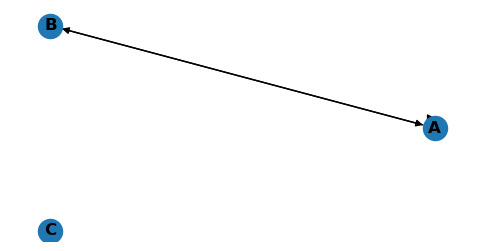

[[ 1  1  0]
 [-1  0  0]
 [ 0  0  0]]
 Count: 503, prob. : 0.17989985693848354


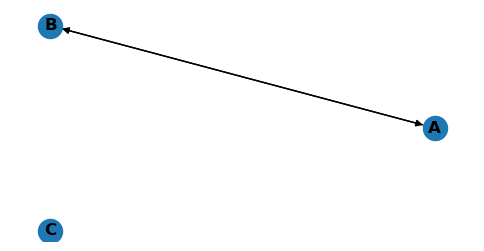

[[ 0  1  0]
 [-1  0  0]
 [ 0  0  0]]
 Count: 249, prob. : 0.0890557939914163


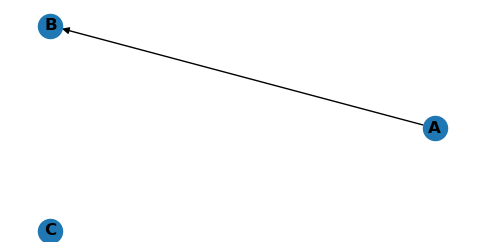

[[0 1 0]
 [0 0 0]
 [0 0 0]]
 Count: 210, prob. : 0.07510729613733906


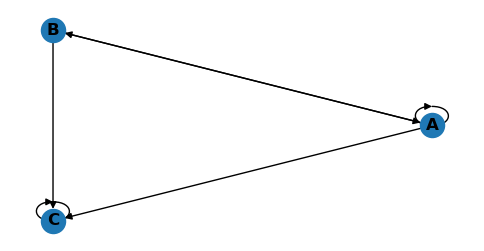

[[ 1  1 -1]
 [-1  0 -1]
 [ 0  0  1]]
 Count: 155, prob. : 0.05543633762517883


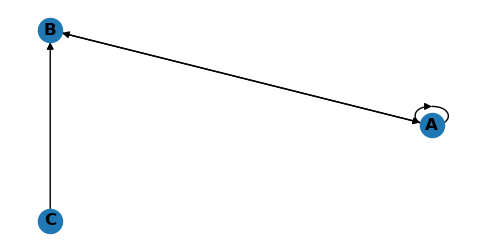

[[ 1  1  0]
 [-1  0  0]
 [ 0 -1  0]]
 Count: 106, prob. : 0.03791130185979971


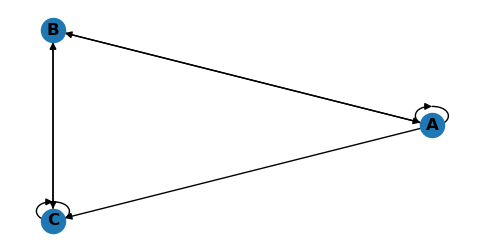

[[ 1  1 -1]
 [-1  0 -1]
 [ 0 -1  1]]
 Count: 101, prob. : 0.03612303290414878


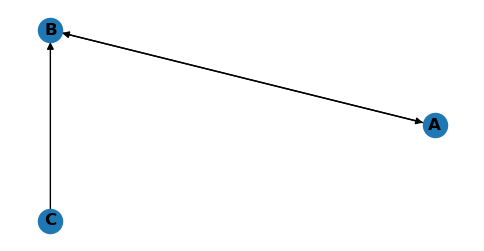

[[ 0  1  0]
 [-1  0  0]
 [ 0 -1  0]]
 Count: 78, prob. : 0.027896995708154508


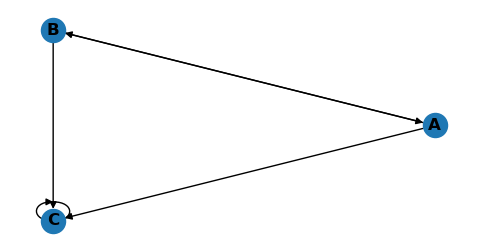

[[ 0  1 -1]
 [-1  0 -1]
 [ 0  0  1]]
 Count: 62, prob. : 0.022174535050071532


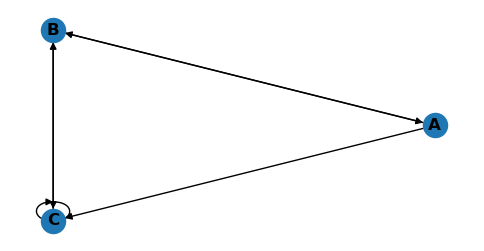

[[ 0  1 -1]
 [-1  0 -1]
 [ 0 -1  1]]
 Count: 46, prob. : 0.016452074391988557


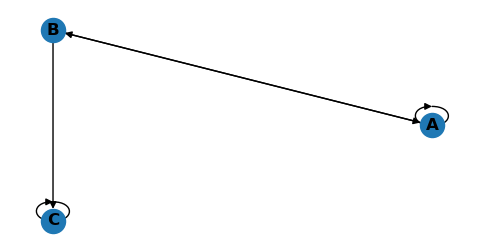

[[ 1  1  0]
 [-1  0 -1]
 [ 0  0  1]]
 Count: 39, prob. : 0.013948497854077254


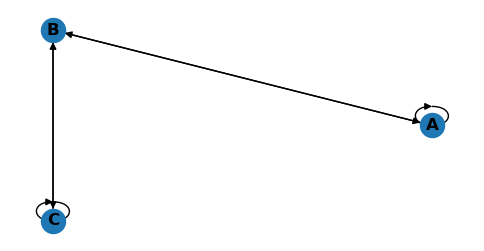

[[ 1  1  0]
 [-1  0 -1]
 [ 0 -1  1]]
 Count: 26, prob. : 0.009298998569384835


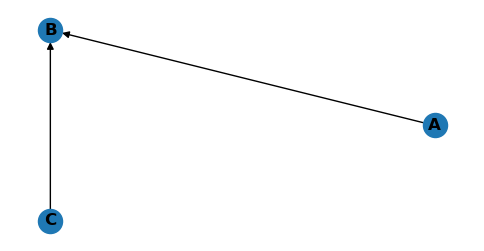

[[ 0  1  0]
 [ 0  0  0]
 [ 0 -1  0]]
 Count: 22, prob. : 0.007868383404864092


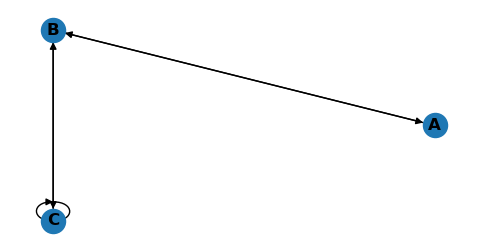

[[ 0  1  0]
 [-1  0 -1]
 [ 0 -1  1]]
 Count: 19, prob. : 0.006795422031473534


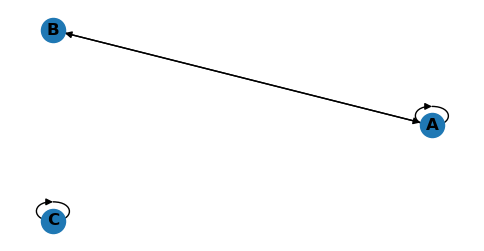

[[ 1  1  0]
 [-1  0  0]
 [ 0  0  1]]
 Count: 14, prob. : 0.005007153075822604


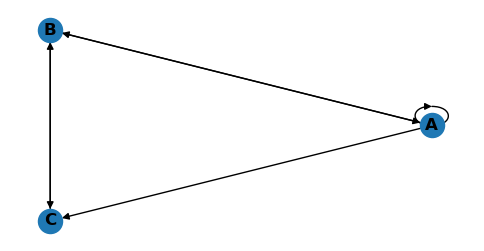

[[ 1  1 -1]
 [-1  0 -1]
 [ 0 -1  0]]
 Count: 11, prob. : 0.003934191702432046


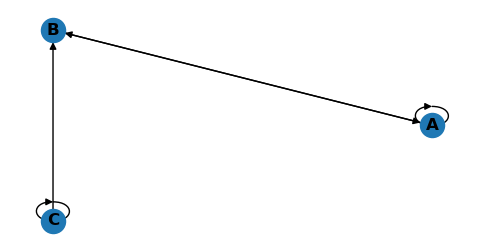

[[ 1  1  0]
 [-1  0  0]
 [ 0 -1  1]]
 Count: 7, prob. : 0.002503576537911302


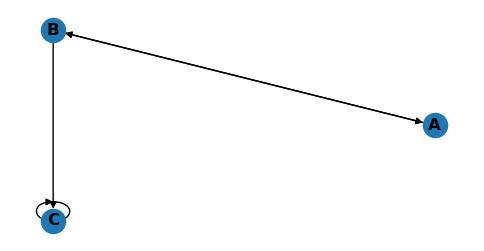

[[ 0  1  0]
 [-1  0 -1]
 [ 0  0  1]]
 Count: 5, prob. : 0.00178826895565093


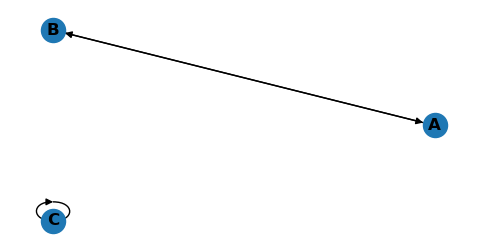

[[ 0  1  0]
 [-1  0  0]
 [ 0  0  1]]
 Count: 3, prob. : 0.001072961373390558


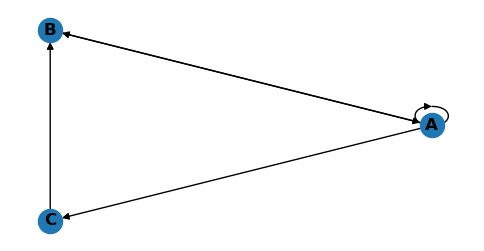

[[ 1  1 -1]
 [-1  0  0]
 [ 0 -1  0]]
 Count: 3, prob. : 0.001072961373390558


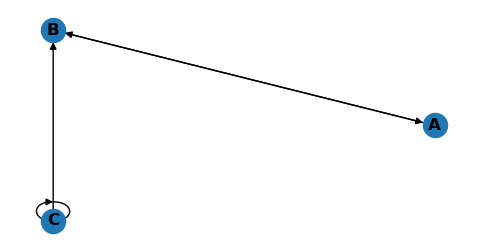

[[ 0  1  0]
 [-1  0  0]
 [ 0 -1  1]]
 Count: 3, prob. : 0.001072961373390558


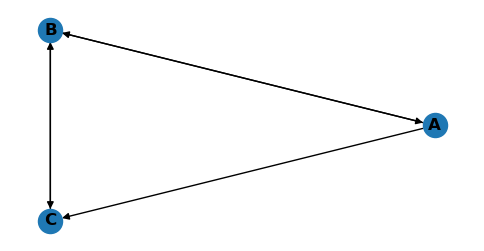

[[ 0  1 -1]
 [-1  0 -1]
 [ 0 -1  0]]
 Count: 2, prob. : 0.000715307582260372


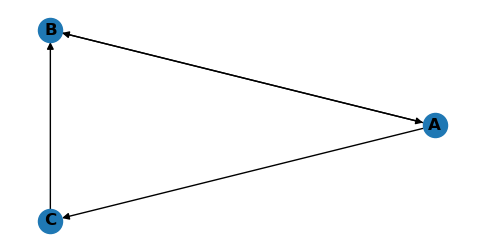

[[ 0  1 -1]
 [-1  0  0]
 [ 0 -1  0]]
 Count: 1, prob. : 0.000357653791130186


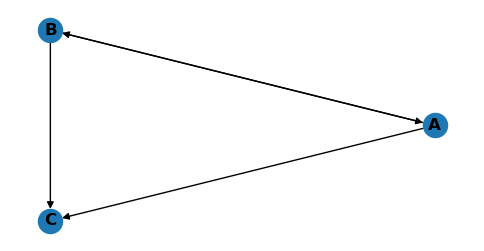

[[ 0  1 -1]
 [-1  0 -1]
 [ 0  0  0]]
 Count: 1, prob. : 0.000357653791130186


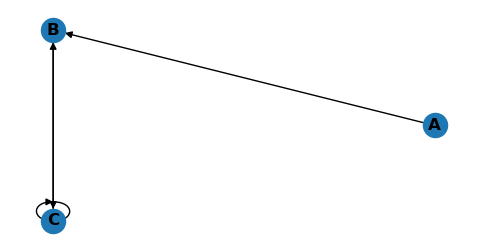

[[ 0  1  0]
 [ 0  0 -1]
 [ 0 -1  1]]
 Count: 1, prob. : 0.000357653791130186


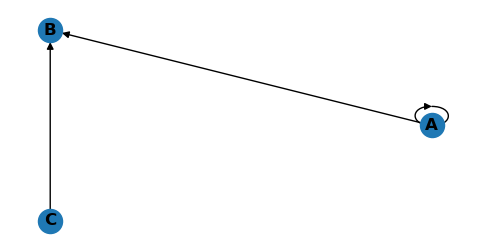

[[ 1  1  0]
 [ 0  0  0]
 [ 0 -1  0]]


In [43]:
total = df.shape[0]
for adj_tup, count in df.groupby("adj_tup")["adj_tup"].count().sort_values(ascending=False).items():
    print("====================================")
    print(f" Count: {count}, prob. : {count/total}")
    adj = np.array(adj_tup).reshape((3,3))
    plot_net(adj)
    print(adj)


In [44]:
net_hist = df.groupby("adj_tup")["adj_tup"].count()
net_hist.iloc[net_hist.index == tuple(original_adj.flatten())]

adj_tup
(1, 1, -1, -1, 0, -1, 0, -1, 1)    106
Name: adj_tup, dtype: int64

In [30]:
selected_params = df[df["adj_tup"] == tuple(original_adj.flatten())].iloc[-2]["params"]
k_max = df[df["adj_tup"] == tuple(original_adj.flatten())].iloc[-2]["k_max"]#["path"]

In [31]:
for g in df.groupby("adj_tup"):
    print(g[0])

(0, 1, -1, -1, 0, -1, 0, -1, 0)
(0, 1, -1, -1, 0, -1, 0, -1, 1)
(0, 1, -1, -1, 0, -1, 0, 0, 0)
(0, 1, -1, -1, 0, -1, 0, 0, 1)
(0, 1, -1, -1, 0, 0, 0, -1, 0)
(0, 1, 0, -1, 0, -1, 0, -1, 1)
(0, 1, 0, -1, 0, -1, 0, 0, 1)
(0, 1, 0, -1, 0, 0, 0, -1, 0)
(0, 1, 0, -1, 0, 0, 0, -1, 1)
(0, 1, 0, -1, 0, 0, 0, 0, 0)
(0, 1, 0, -1, 0, 0, 0, 0, 1)
(0, 1, 0, 0, 0, -1, 0, -1, 1)
(0, 1, 0, 0, 0, 0, 0, -1, 0)
(0, 1, 0, 0, 0, 0, 0, 0, 0)
(1, 1, -1, -1, 0, -1, 0, -1, 0)
(1, 1, -1, -1, 0, -1, 0, -1, 1)
(1, 1, -1, -1, 0, -1, 0, 0, 1)
(1, 1, -1, -1, 0, 0, 0, -1, 0)
(1, 1, 0, -1, 0, -1, 0, -1, 1)
(1, 1, 0, -1, 0, -1, 0, 0, 1)
(1, 1, 0, -1, 0, 0, 0, -1, 0)
(1, 1, 0, -1, 0, 0, 0, -1, 1)
(1, 1, 0, -1, 0, 0, 0, 0, 0)
(1, 1, 0, -1, 0, 0, 0, 0, 1)
(1, 1, 0, 0, 0, 0, 0, -1, 0)


In [220]:
a = [(g[0], g[1]) for g in df.groupby("adj_tup") if g[0] == tuple(original_adj.flatten())]

# Results for Full Topology

In [45]:
Labyrinth = [0, 7, 10, 46, 47, 56, 57, 59, 60, 64, 66]
Spots=[8,12,13,14,15,16,17,23,24,25,27,28,31,32,35,37,38,39,40,43,45,48,49,65,70,73,74,76,77,78,79,80,81,82,87,88,89,91,92,96,97,102,103,105]
Betweens=[1,2,4,5,9,11,29,30,33,36,42,50,51,52,53,55,58,61,62,63,67,68,69,71,75,85,86,94,95,100,101]
Odds=[3,6,20,21,22,26,72,90,93,98,99]
Wrongs=[18,19,34,41,44,54,83,84,104]

In [46]:
subnet_list = [g[1] for g in df.groupby("adj_tup") if g[0] == tuple(original_adj.flatten())]
if len(subnet_list) == 0:
    print("================================")
    print("There is no adjacancy matrix as: ", adj)
    print("================================")
else:
    subnet_df = subnet_list[0]

In [47]:
subnet_df["index"] = list(range(subnet_df.shape[0]))

In [48]:
def type_of(r):
    if r in Labyrinth:
        return "labyrinth"
    elif r in Spots:
        return "spot"
    elif r in Betweens:
        return "in-between"
    elif r in Odds:
        return "odd"
    elif r in Wrongs:
        return "wrong"
    else:
        raise Exception(f"Error: {r}")

In [49]:
subnet_df["type"] = subnet_df["index"].apply(lambda r: type_of(r))

In [50]:
subnet_df.head(2)

,min_A,min_B,min_C,avg_A,avg_B,avg_C,max_A,max_B,max_C,std_A,...,state_CC,lb_CC,ub_CC,Adj,k_max,params,path,adj_tup,index,type
116,0.879311,27.467100,2.000050,3.859942,31.707845,2.000238,6.759598,35.970982,2.000543,1.490110,...,Active,0.880009,28.110281,"[[1, 1, -1], [-1, 0, -1], [0, -1, 1]]",8.430177,"[4.0, 0.001, 0.1, 5.0, 5.0, 5.0, 5.0, 0.5, 0.5...",outputs_second_search/solution_10_0_24.npy,"(1, 1, -1, -1, 0, -1, 0, -1, 1)",0,labyrinth
118,0.116436,4.861978,2.007392,2.592416,5.722580,2.102208,7.983336,6.991984,2.186170,2.202455,...,Active,0.880009,28.110281,"[[1, 1, -1], [-1, 0, -1], [0, -1, 1]]",30.497638,"[4.0, 0.001, 0.1, 5.0, 5.0, 5.0, 5.0, 1.0, 0.5...",outputs_second_search/solution_10_0_26.npy,"(1, 1, -1, -1, 0, -1, 0, -1, 1)",1,in-between


In [51]:
subnet_df.to_csv("df_network_analysis_full_topology.csv",index=False)

In [259]:
subnet_df.loc[subnet_df["index"] == 99]["type"]

2772    odd
Name: type, dtype: object

In [17]:

with open("./outputs_second_search/solution_10_0_27_3.npy", "rb") as f:
    test = np.load(f, allow_pickle=True)

In [21]:
"./outputs_second_search/solution_10_0_27_3.npy".count("_")

6

In [33]:
df.iloc[0]

min_A                                                0.267348
min_B                                               25.862611
min_C                                                     0.2
avg_A                                                0.519577
avg_B                                               26.766894
avg_C                                                     0.2
max_A                                                0.613787
max_B                                               27.038456
max_C                                                     0.2
std_A                                                0.043833
std_B                                                0.173963
std_C                                                     0.0
state_AA                                               Active
lb_AA                                                0.080001
ub_AA                                                2.820028
state_AB                                               Active
lb_AB   

In [42]:
subnet_df.iloc[0]

min_A                                                0.879311
min_B                                                 27.4671
min_C                                                 2.00005
avg_A                                                3.859942
avg_B                                               31.707845
avg_C                                                2.000238
max_A                                                6.759598
max_B                                               35.970982
max_C                                                2.000543
std_A                                                 1.49011
std_B                                                1.987235
std_C                                                 0.00013
state_AA                                               Active
lb_AA                                                0.880009
ub_AA                                               28.110281
state_AB                                               Active
lb_AB   